#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 16, 2025

<br>

In [102]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [103]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [104]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [105]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [106]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first column
gpts_full_labels = gpts_full_labels.drop(gpts_full_labels.columns[:1], axis=1)

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2


In [107]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 0


## Replication of Eloundou et al. (2024) Measures

In [108]:
# Reconstruct the occ_level exposure dataset from the original paper
def compute_exposure_shares(df, exposure_col, prefix):
    # Weight core vs. supplemental tasks (if column exists)
    df["task_weight"] = df["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)

    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)

    # Weighted shares per occupation
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Occupation Title"])
        .apply(lambda x: pd.Series({
            f"{prefix}_E1_share": (x[f"{prefix}_E1"] * x["task_weight"]).sum() / x["task_weight"].sum(),
            f"{prefix}_E2_share": (x[f"{prefix}_E2"] * x["task_weight"]).sum() / x["task_weight"].sum(),
        }))
        .reset_index()
    )

    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"]     = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]

    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])

    occ_level = occ_level.rename(columns={'gpt4_E1_share': 'gpt4_alpha',
                                          'gpt4_E1_plus_halfE2': 'gpt4_beta',
                                          'gpt4_E1_plus_E2': 'gpt4_gamma',
                                          'human_E1_share': 'human_alpha',
                                          'human_E1_plus_halfE2': 'human_beta',
                                          'human_E1_plus_E2': 'human_gamma'})

    return occ_level


# Compute exposure shares for GPT-4 and human ratings
gpt4_exposure_scores = compute_exposure_shares(ONET, "gpt4_exposure", "gpt4")
human_exposure_scores = compute_exposure_shares(ONET, "human_labels", "human")

# Merge GPT-4 and human exposure scores on occupation code and title
exposure_scores_occupation = pd.merge(gpt4_exposure_scores, human_exposure_scores, 
                                     on=["O*NET-SOC Code", "Occupation Title"])

# Save the combined exposure scores to CSV
# exposure_scores_occupation.to_csv(f'{output_data_path}/exposure_scores_occupation.csv', index=False)
# print(f"Saved combined exposure scores to: {output_data_path}/exposure_scores_occupation.csv")
print(f"Number of occupations: {len(exposure_scores_occupation)}")

# Display the results
exposure_scores_occupation.head()

Number of occupations: 873


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,11-1011.00,Chief Executives,0.10,0.46,0.82,0.18,0.35,0.52
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72
2,11-1021.00,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65
3,11-2011.00,Advertising and Promotions Managers,0.00,0.49,0.97,0.32,0.57,0.82
4,11-2021.00,Marketing Managers,0.06,0.50,0.94,0.22,0.58,0.94


### Add additional columns to replicated measures and save

In [109]:
# Enrich exposure_scores_occupation with hierarchical ONET codes/titles (Major, Minor, Broad, Detailed), add task counts, and save
print('\nAdding ONET hierarchy columns to exposure_scores_occupation and merging unique task counts; saving as ONET_tasklevel_exposure.csv')

# Select unique occupation-level mapping from ONET
occupation_map = ONET.drop_duplicates(subset=['O*NET-SOC Code', 'Occupation Title'])[[
    'O*NET-SOC Code', 'Occupation Title',
    'Major_Group_Code', 'Major_Group_Title',
    'Minor_Group_Code', 'Minor_Group_Title',
    'Broad_Occupation_Code', 'Broad_Occupation_Title',
    'Detailed_Occupation_Code', 'Detailed_Occupation_Title'
    ]]

# Merge with exposure_scores_occupation
exposure_scores_occupation = exposure_scores_occupation.merge(
    occupation_map,
    on=['O*NET-SOC Code', 'Occupation Title'],
    how='left'
    )

# Compute number of unique tasks per occupation and merge into the enriched dataset
task_counts = ONET.groupby(['O*NET-SOC Code', 'Occupation Title'])['Task ID'].nunique().reset_index()
task_counts = task_counts.rename(columns={'Task ID': 'num_unique_tasks'})

exposure_scores_occupation = exposure_scores_occupation.merge(
    task_counts,
    on=['O*NET-SOC Code', 'Occupation Title'],
    how='left'
    )

# Save to CSV
exposure_scores_occupation.to_csv(f'{output_data_path}/ONET_tasklevel_exposure.csv', index=False)
print(f"✓ Saved enriched exposure dataset with task counts to: {output_data_path}/ONET_tasklevel_exposure.csv")

# Display sample
exposure_scores_occupation.head()


Adding ONET hierarchy columns to exposure_scores_occupation and merging unique task counts; saving as ONET_tasklevel_exposure.csv
✓ Saved enriched exposure dataset with task counts to: ../data/computed_objects/ONET_tasklevel_exposure.csv


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,num_unique_tasks
0,11-1011.00,Chief Executives,0.10,0.46,0.82,0.18,0.35,0.52,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,31
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,18
2,11-1021.00,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65,11-0000,Management Occupations,11-1000,Top Executives,11-1020,General and Operations Managers,11-1021,General and Operations Managers,17
3,11-2011.00,Advertising and Promotions Managers,0.00,0.49,0.97,0.32,0.57,0.82,11-0000,Management Occupations,11-2000,"Advertising, Marketing, Promotions, Public Rel...",11-2010,Advertising and Promotions Managers,11-2011,Advertising and Promotions Managers,21
4,11-2021.00,Marketing Managers,0.06,0.50,0.94,0.22,0.58,0.94,11-0000,Management Occupations,11-2000,"Advertising, Marketing, Promotions, Public Rel...",11-2020,Marketing and Sales Managers,11-2021,Marketing Managers,20


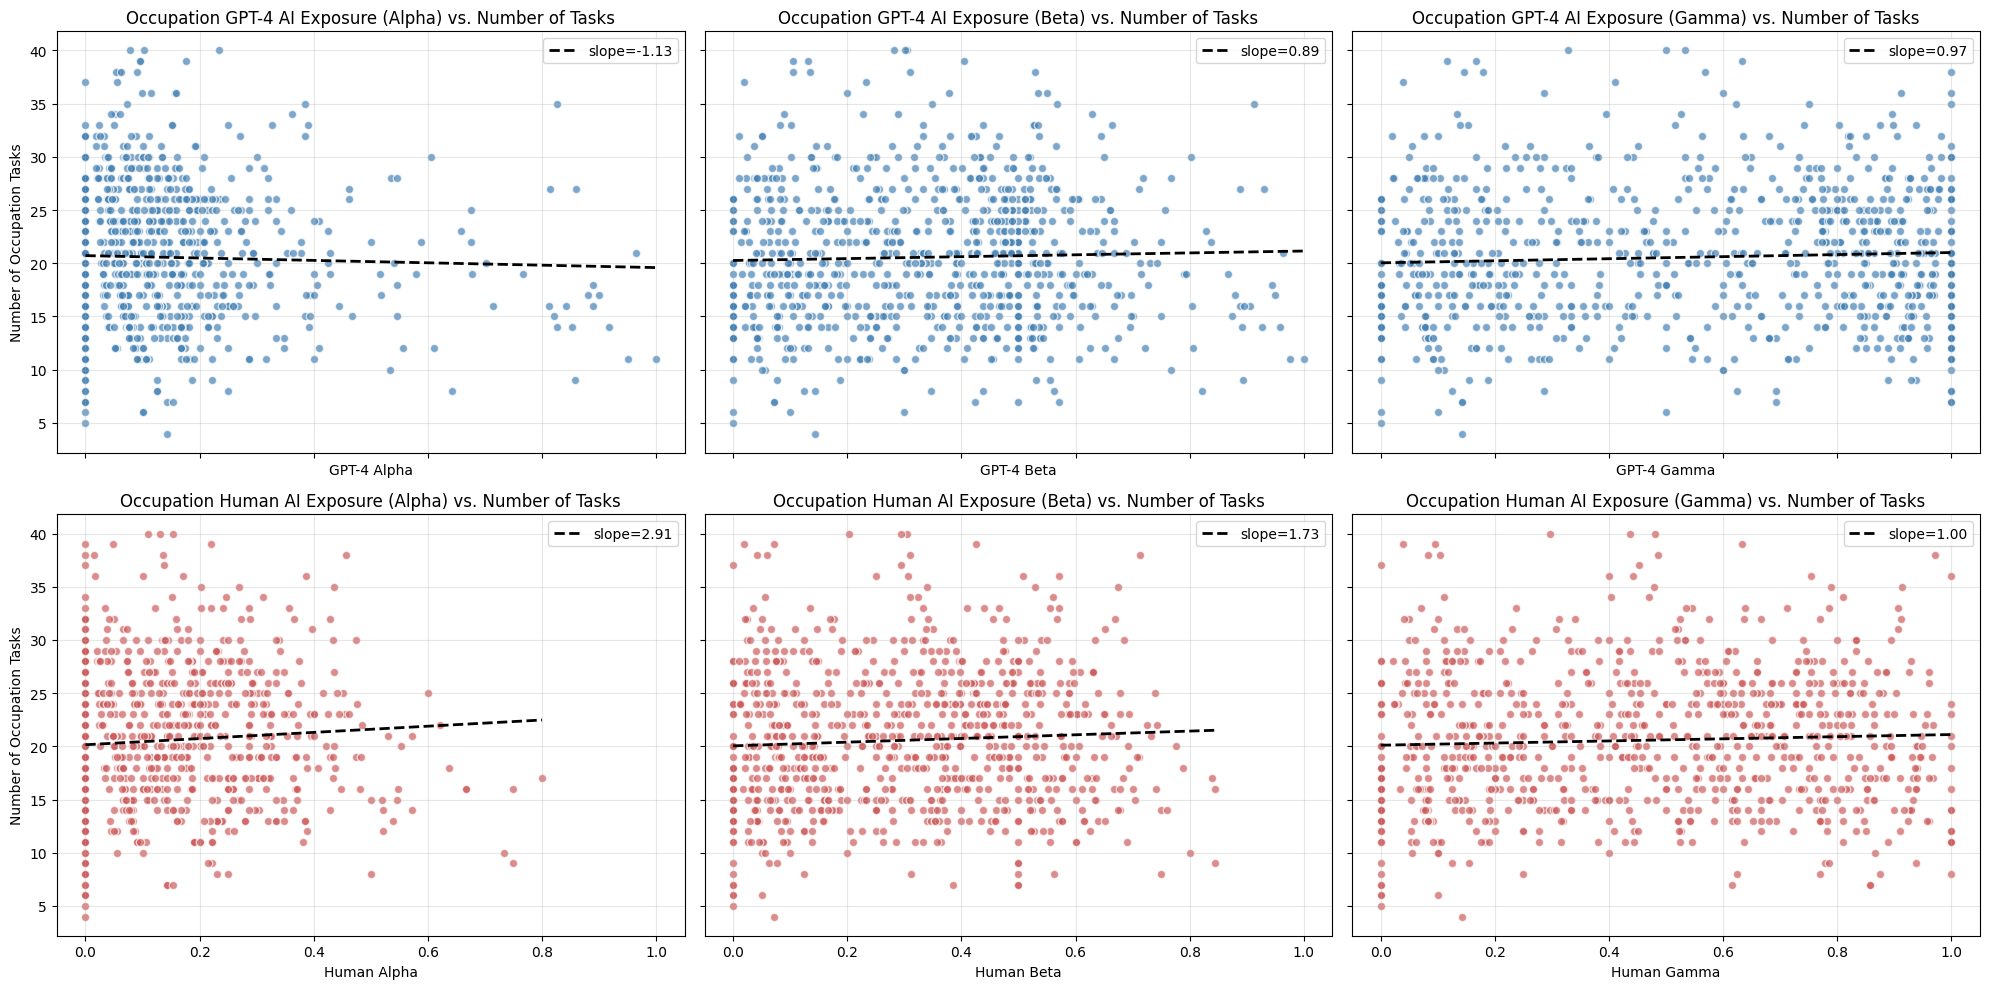

✓ Saved combined 2x3 scatter figure to: ../writeup/plots/taskcounts_aiexposure/numtasks_vs_exposure_occupation.png


In [110]:
# Define exposure measures and labels
measures = ['alpha', 'beta', 'gamma']
import numpy as _np

# Create combined 2x3 figure (2 rows: GPT-4, Human; 3 columns: alpha,beta,gamma)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex='col', sharey='row')
# Top row: GPT-4
for i, measure in enumerate(measures):
    ax = axes[0, i]
    x = exposure_scores_occupation[f'gpt4_{measure}'].astype(float)
    y = exposure_scores_occupation['num_unique_tasks'].astype(float)
    ax.scatter(x, y, alpha=0.7, color='steelblue', edgecolors='white')
    # Fit linear regression line if we have enough valid points
    valid_mask = (~_np.isnan(x)) & (~_np.isnan(y))
    if valid_mask.sum() > 1:
        coeffs = _np.polyfit(x[valid_mask], y[valid_mask], 1)
        x_fit = _np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
        y_fit = coeffs[0] * x_fit + coeffs[1]
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
        ax.legend()
    ax.set_xlabel(f'GPT-4 {measure.capitalize()}')
    if i == 0:
        ax.set_ylabel('Number of Occupation Tasks')
    ax.set_title(f'Occupation GPT-4 AI Exposure ({measure.capitalize()}) vs. Number of Tasks')
    ax.grid(True, alpha=0.3)

# Bottom row: Human
for i, measure in enumerate(measures):
    ax = axes[1, i]
    x = exposure_scores_occupation[f'human_{measure}'].astype(float)
    y = exposure_scores_occupation['num_unique_tasks'].astype(float)
    ax.scatter(x, y, alpha=0.7, color='indianred', edgecolors='white')
    # Fit linear regression line if we have enough valid points
    valid_mask = (~_np.isnan(x)) & (~_np.isnan(y))
    if valid_mask.sum() > 1:
        coeffs = _np.polyfit(x[valid_mask], y[valid_mask], 1)
        x_fit = _np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
        y_fit = coeffs[0] * x_fit + coeffs[1]
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
        ax.legend()
    ax.set_xlabel(f'Human {measure.capitalize()}')
    if i == 0:
        ax.set_ylabel('Number of Occupation Tasks')
    ax.set_title(f'Occupation Human AI Exposure ({measure.capitalize()}) vs. Number of Tasks')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
combined_plot_file = f'{output_plot_path}/taskcounts_aiexposure/numtasks_vs_exposure_occupation.png'
plt.savefig(combined_plot_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved combined 2x3 scatter figure to: {combined_plot_file}")

## Use Occupation-level AI Exposure Measures to Calculate Industry Group-level Exposure Levels

In [111]:
# Create and save industry group-level exposure datasets (Major, Minor, Broad, Detailed)
import os
print('Creating industry group-level exposure datasets and saving to data/industryGroup_exposure')
group_levels = [
    ('Major_Group_Code', 'Major_Group_Title'),
    ('Minor_Group_Code', 'Minor_Group_Title'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title')
]
exposure_cols = [
    'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
    'human_alpha', 'human_beta', 'human_gamma'
]
output_dir = f'{output_data_path}/industryGroup_exposure'
os.makedirs(output_dir, exist_ok=True)
for code_col, title_col in group_levels:
    # Build occupation-level mapping and ensure num_unique_tasks present
    # exposure_scores_occupation already contains num_unique_tasks and ONET hierarchy columns
    agg_funcs = {col: 'mean' for col in exposure_cols}
    agg_funcs.update({'O*NET-SOC Code': 'nunique', 'num_unique_tasks': 'sum'})
    group_df = exposure_scores_occupation.groupby([code_col, title_col]).agg(agg_funcs).reset_index()
    group_df = group_df.rename(columns={'O*NET-SOC Code': 'num_unique_occupations'})
    # Save dataset to data folder
    out_file = f'{output_dir}/{code_col}_exposure.csv'
    group_df.to_csv(out_file, index=False)
    print(f'✓ Saved {code_col} exposure dataset to: {out_file}')
    display(group_df.head())

Creating industry group-level exposure datasets and saving to data/industryGroup_exposure
✓ Saved Major_Group_Code exposure dataset to: ../data/computed_objects/industryGroup_exposure/Major_Group_Code_exposure.csv


,Major_Group_Code,Major_Group_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-0000,Management Occupations,0.07,0.47,0.86,0.19,0.43,0.68,50,1063
1,13-0000,Business and Financial Operations Occupations,0.15,0.53,0.91,0.26,0.52,0.78,43,871
2,15-0000,Computer and Mathematical Occupations,0.50,0.73,0.97,0.29,0.60,0.91,29,606
3,17-0000,Architecture and Engineering Occupations,0.16,0.49,0.83,0.19,0.43,0.66,55,1157
4,19-0000,"Life, Physical, and Social Science Occupations",0.12,0.46,0.80,0.28,0.50,0.71,57,1168


✓ Saved Minor_Group_Code exposure dataset to: ../data/computed_objects/industryGroup_exposure/Minor_Group_Code_exposure.csv


,Minor_Group_Code,Minor_Group_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1000,Top Executives,0.09,0.50,0.91,0.12,0.37,0.63,3,66
1,11-2000,"Advertising, Marketing, Promotions, Public Rel...",0.02,0.48,0.94,0.21,0.54,0.88,3,58
2,11-3000,Operations Specialties Managers,0.06,0.45,0.85,0.15,0.42,0.68,14,271
3,11-9000,Other Management Occupations,0.07,0.44,0.82,0.20,0.40,0.60,10,234
4,13-1000,Business Operations Specialists,0.15,0.51,0.87,0.25,0.47,0.68,20,404


✓ Saved Broad_Occupation_Code exposure dataset to: ../data/computed_objects/industryGroup_exposure/Broad_Occupation_Code_exposure.csv


,Broad_Occupation_Code,Broad_Occupation_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1010,Chief Executives,0.13,0.51,0.88,0.12,0.37,0.62,2,49
1,11-1020,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65,1,17
2,11-2010,Advertising and Promotions Managers,0.00,0.49,0.97,0.32,0.57,0.82,1,21
3,11-2020,Marketing and Sales Managers,0.03,0.47,0.92,0.16,0.53,0.90,2,37
4,11-3010,Administrative Services and Facilities Managers,0.00,0.35,0.69,0.23,0.50,0.77,1,8


✓ Saved Detailed_Occupation_Code exposure dataset to: ../data/computed_objects/industryGroup_exposure/Detailed_Occupation_Code_exposure.csv


,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1011,Chief Executives,0.13,0.51,0.88,0.12,0.37,0.62,2,49
1,11-1021,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65,1,17
2,11-2011,Advertising and Promotions Managers,0.00,0.49,0.97,0.32,0.57,0.82,1,21
3,11-2021,Marketing Managers,0.06,0.50,0.94,0.22,0.58,0.94,1,20
4,11-2022,Sales Managers,0.00,0.45,0.90,0.10,0.48,0.87,1,17


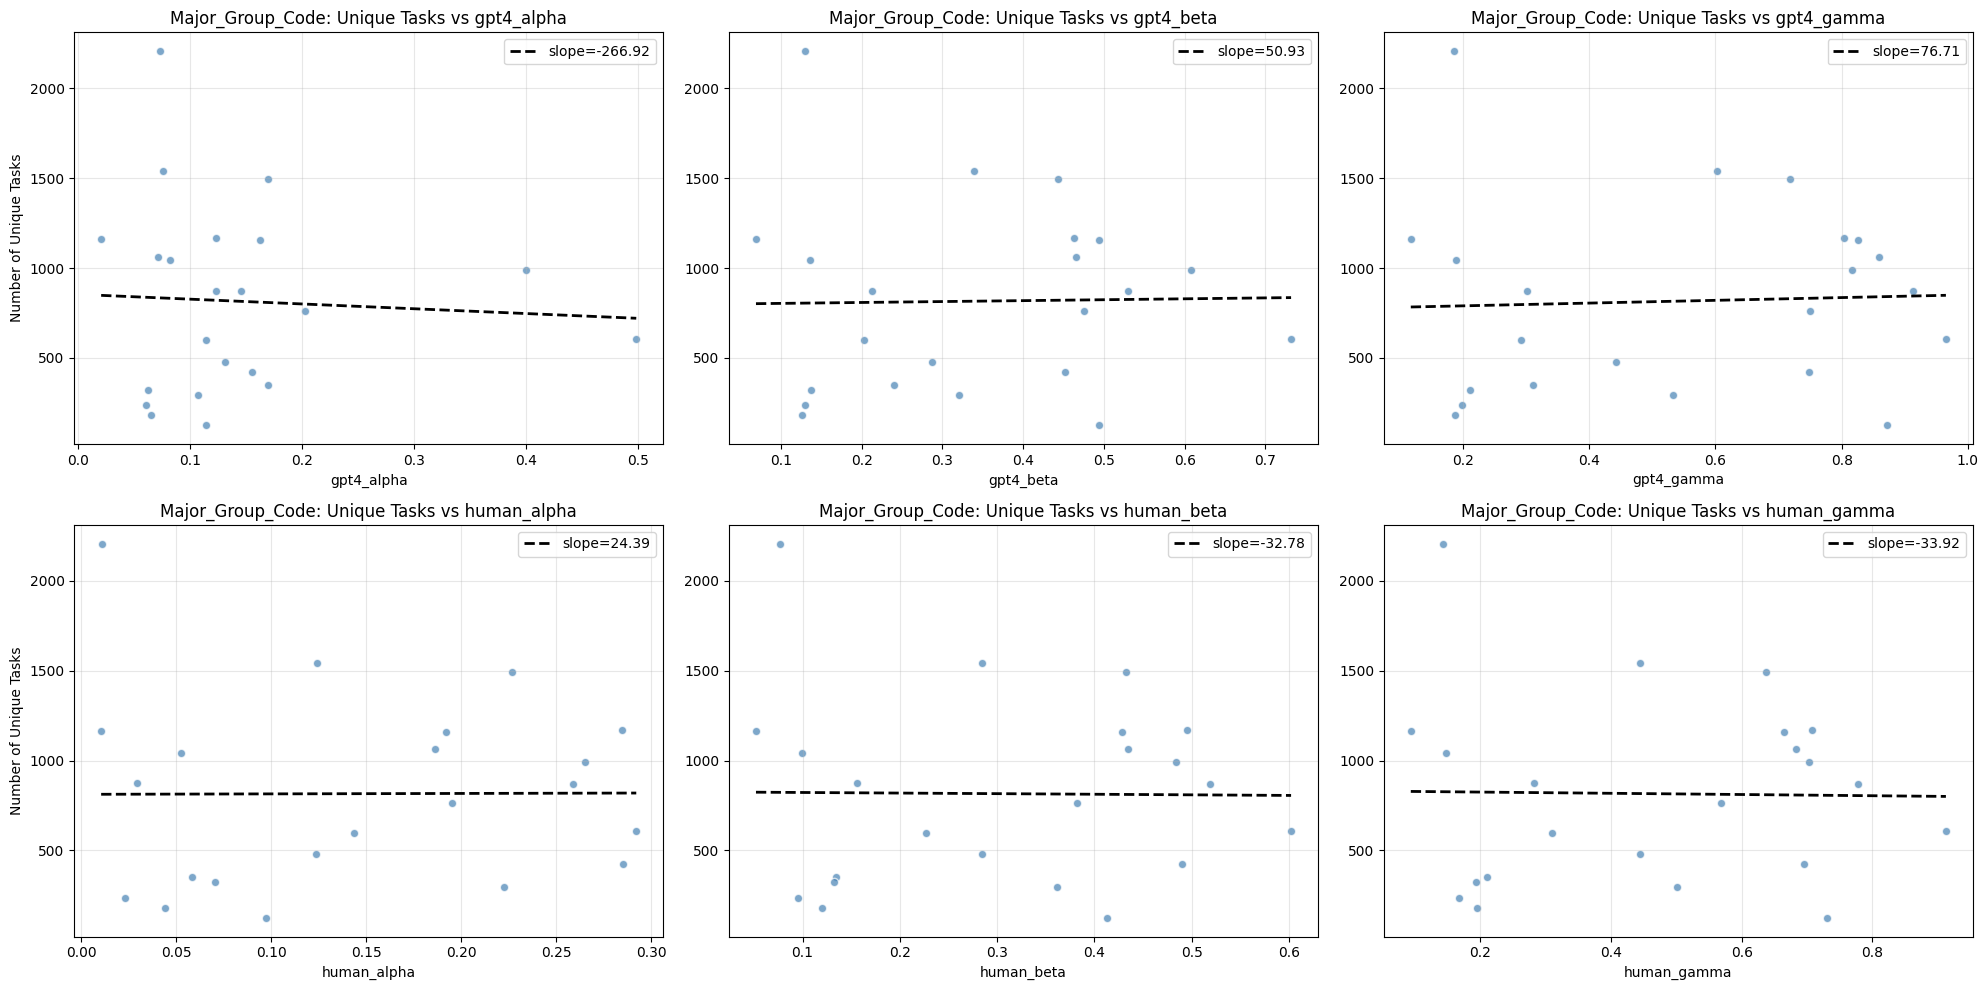

✓ Saved Major_Group_Code tasks vs exposure plot to: ../writeup/plots/industryGroup_exposure/Major_Group_Code_tasks_vs_exposure.png


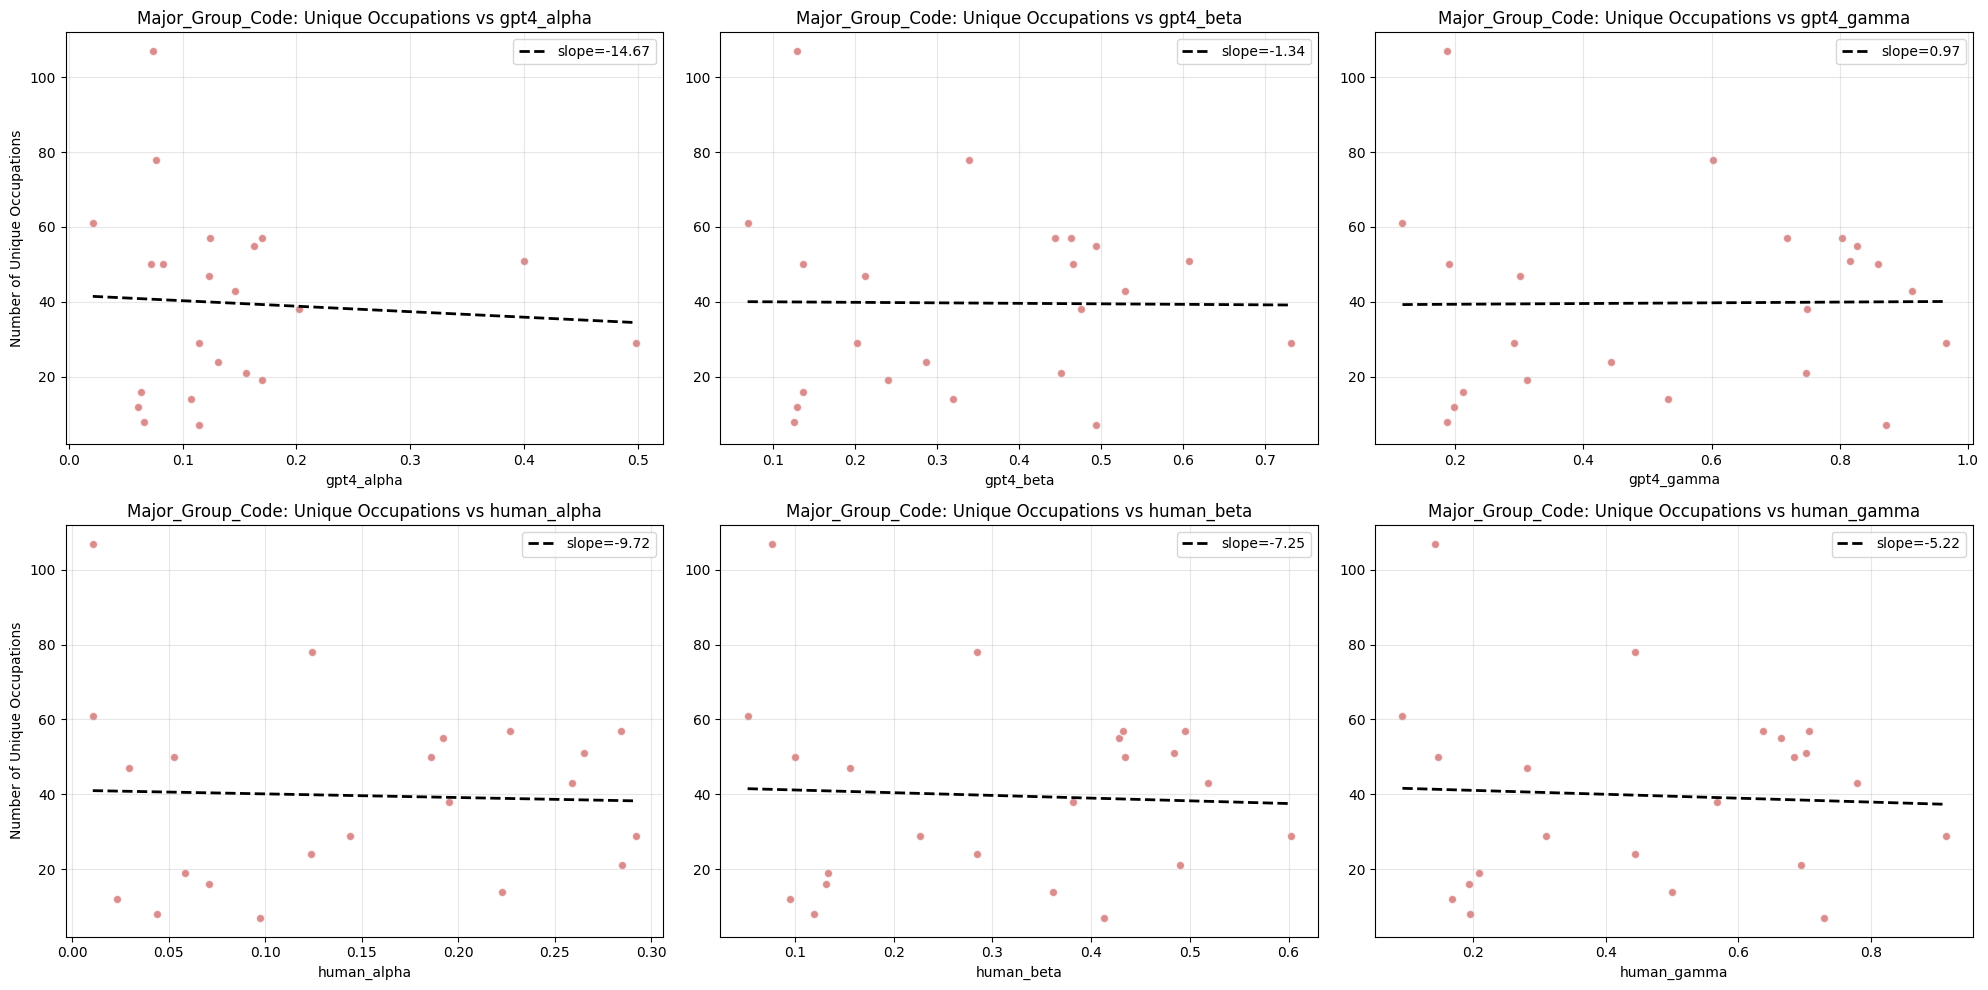

✓ Saved Major_Group_Code occupations vs exposure plot to: ../writeup/plots/industryGroup_exposure/Major_Group_Code_occupations_vs_exposure.png


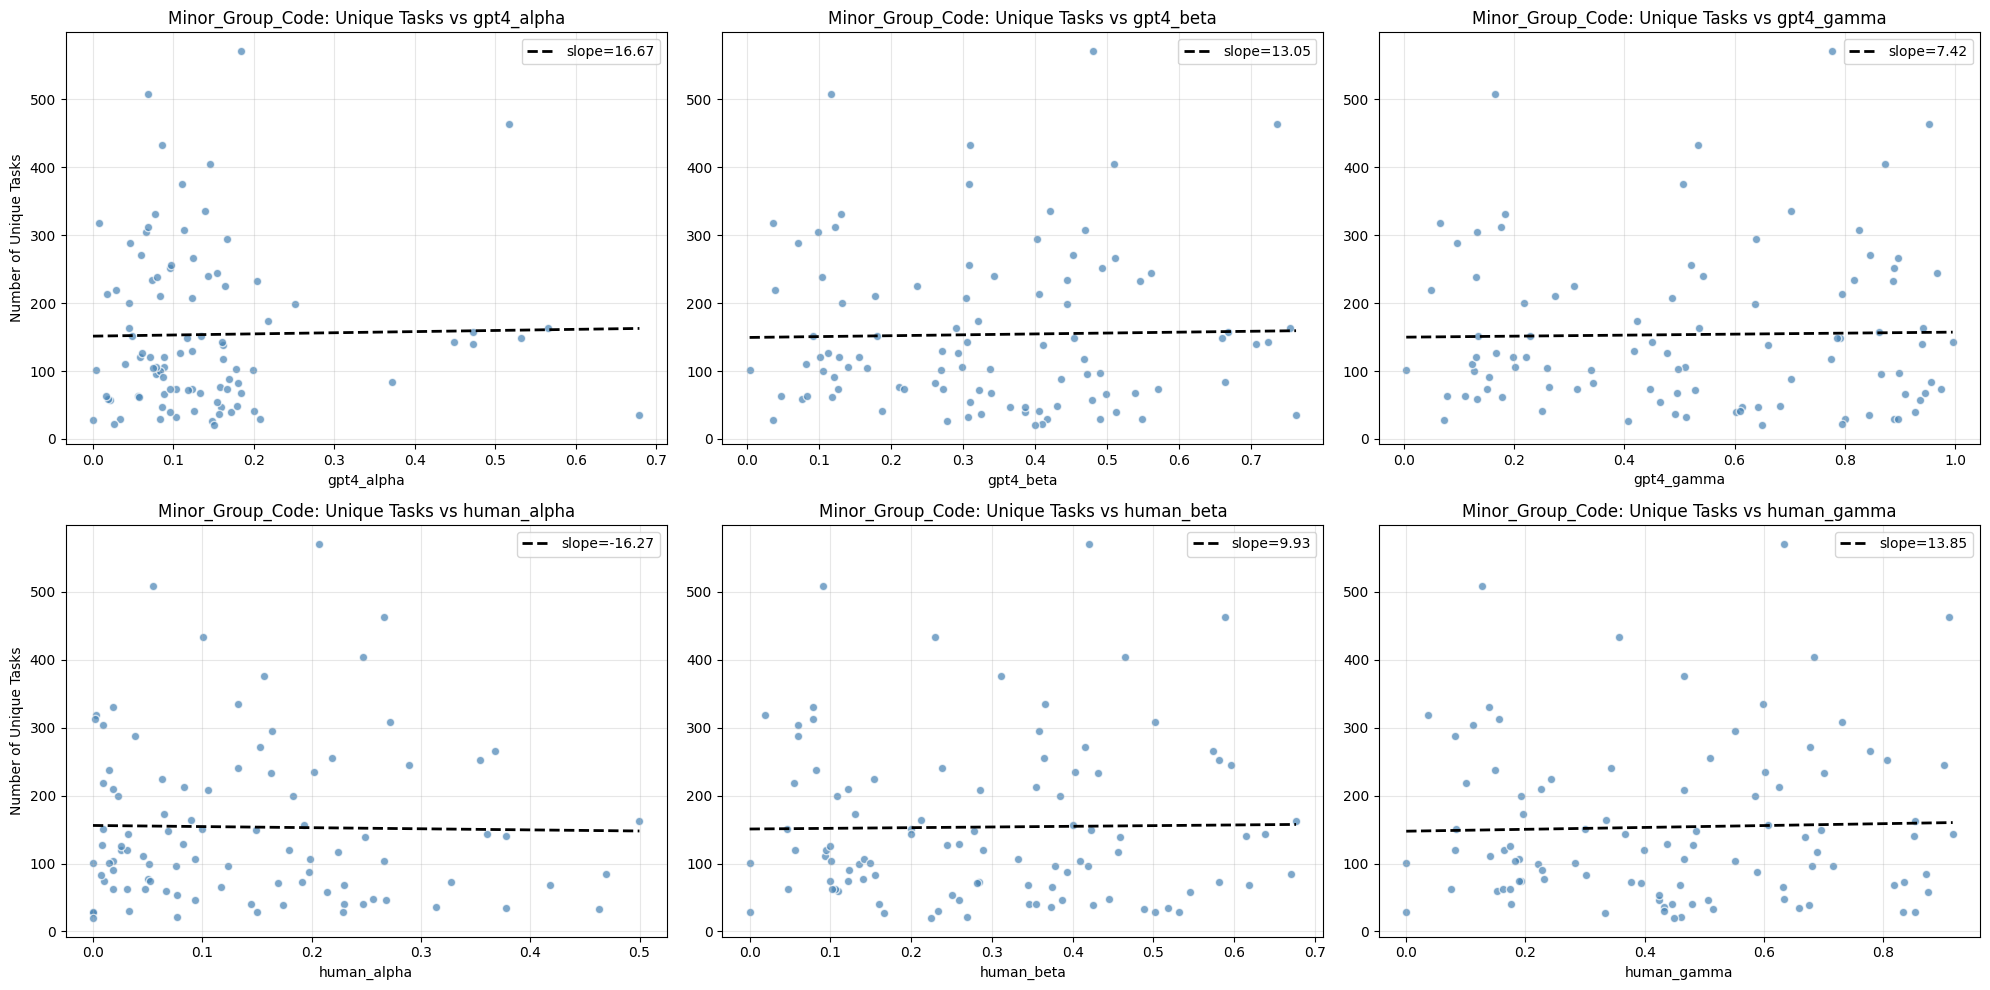

✓ Saved Minor_Group_Code tasks vs exposure plot to: ../writeup/plots/industryGroup_exposure/Minor_Group_Code_tasks_vs_exposure.png


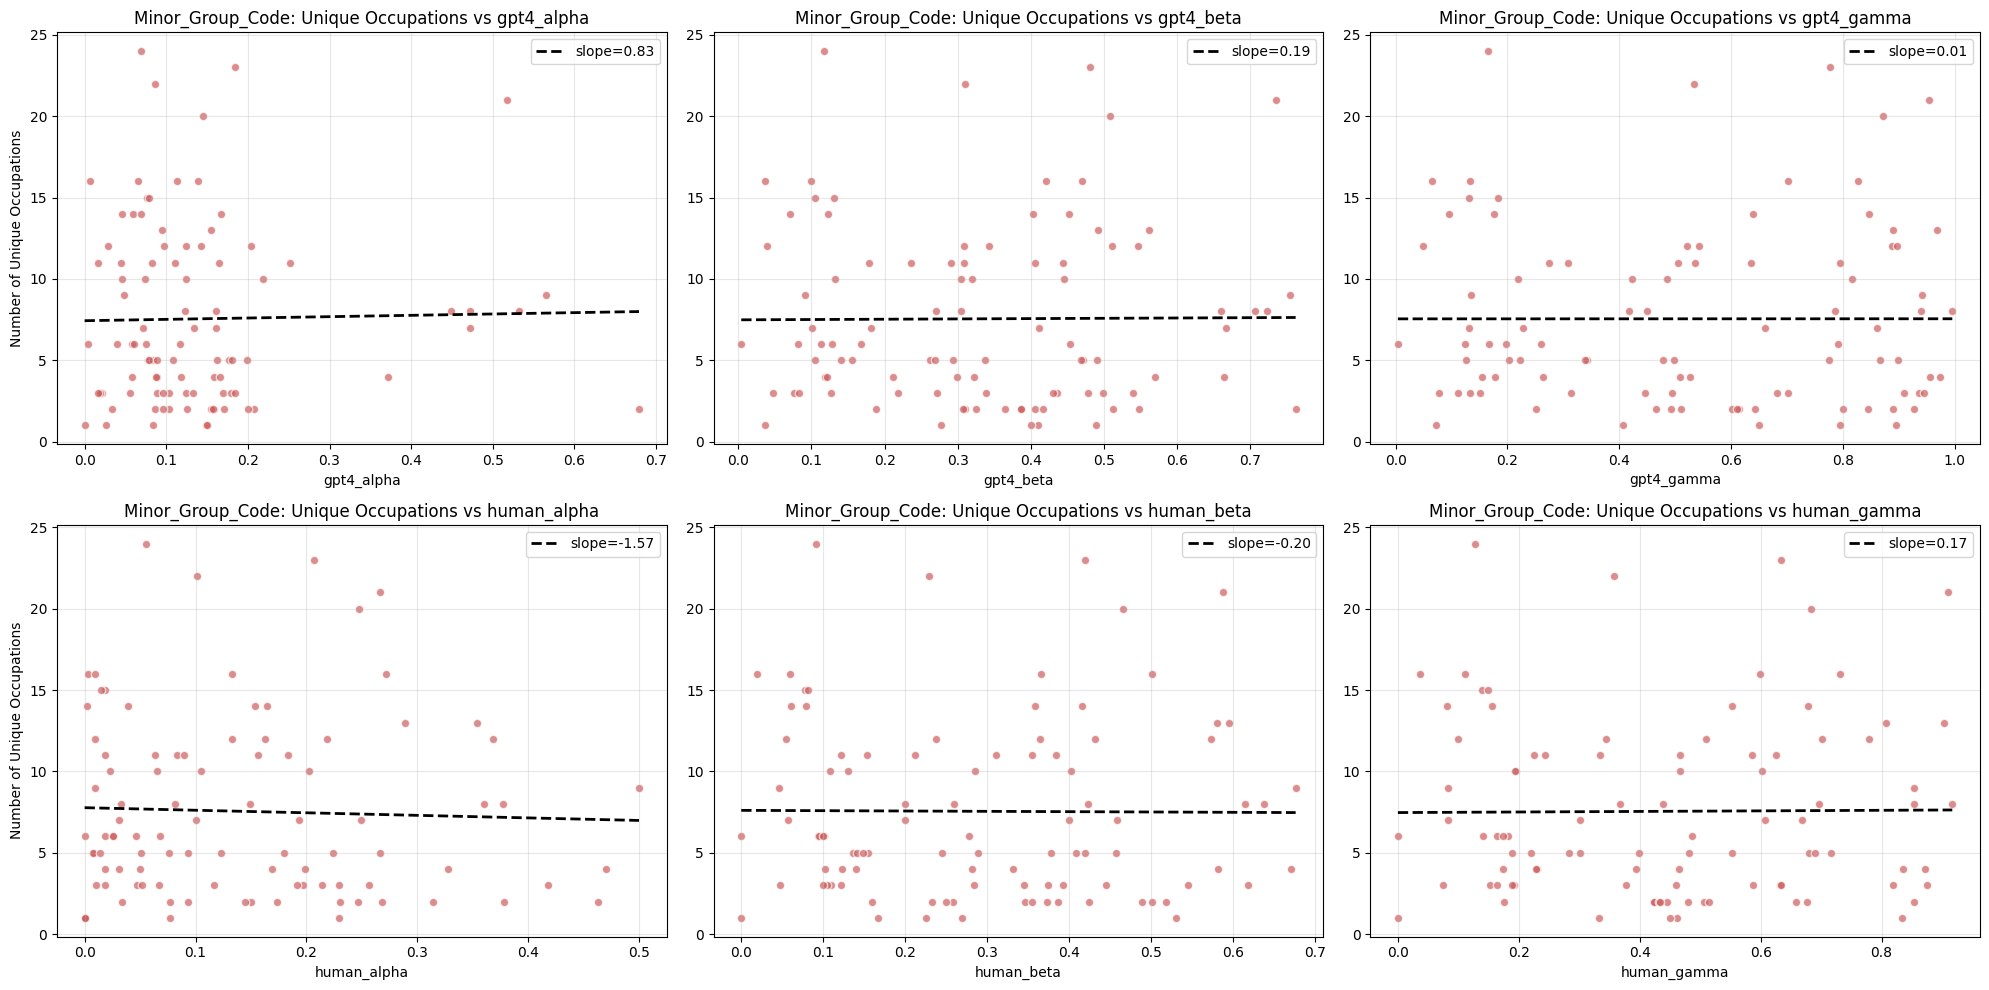

✓ Saved Minor_Group_Code occupations vs exposure plot to: ../writeup/plots/industryGroup_exposure/Minor_Group_Code_occupations_vs_exposure.png


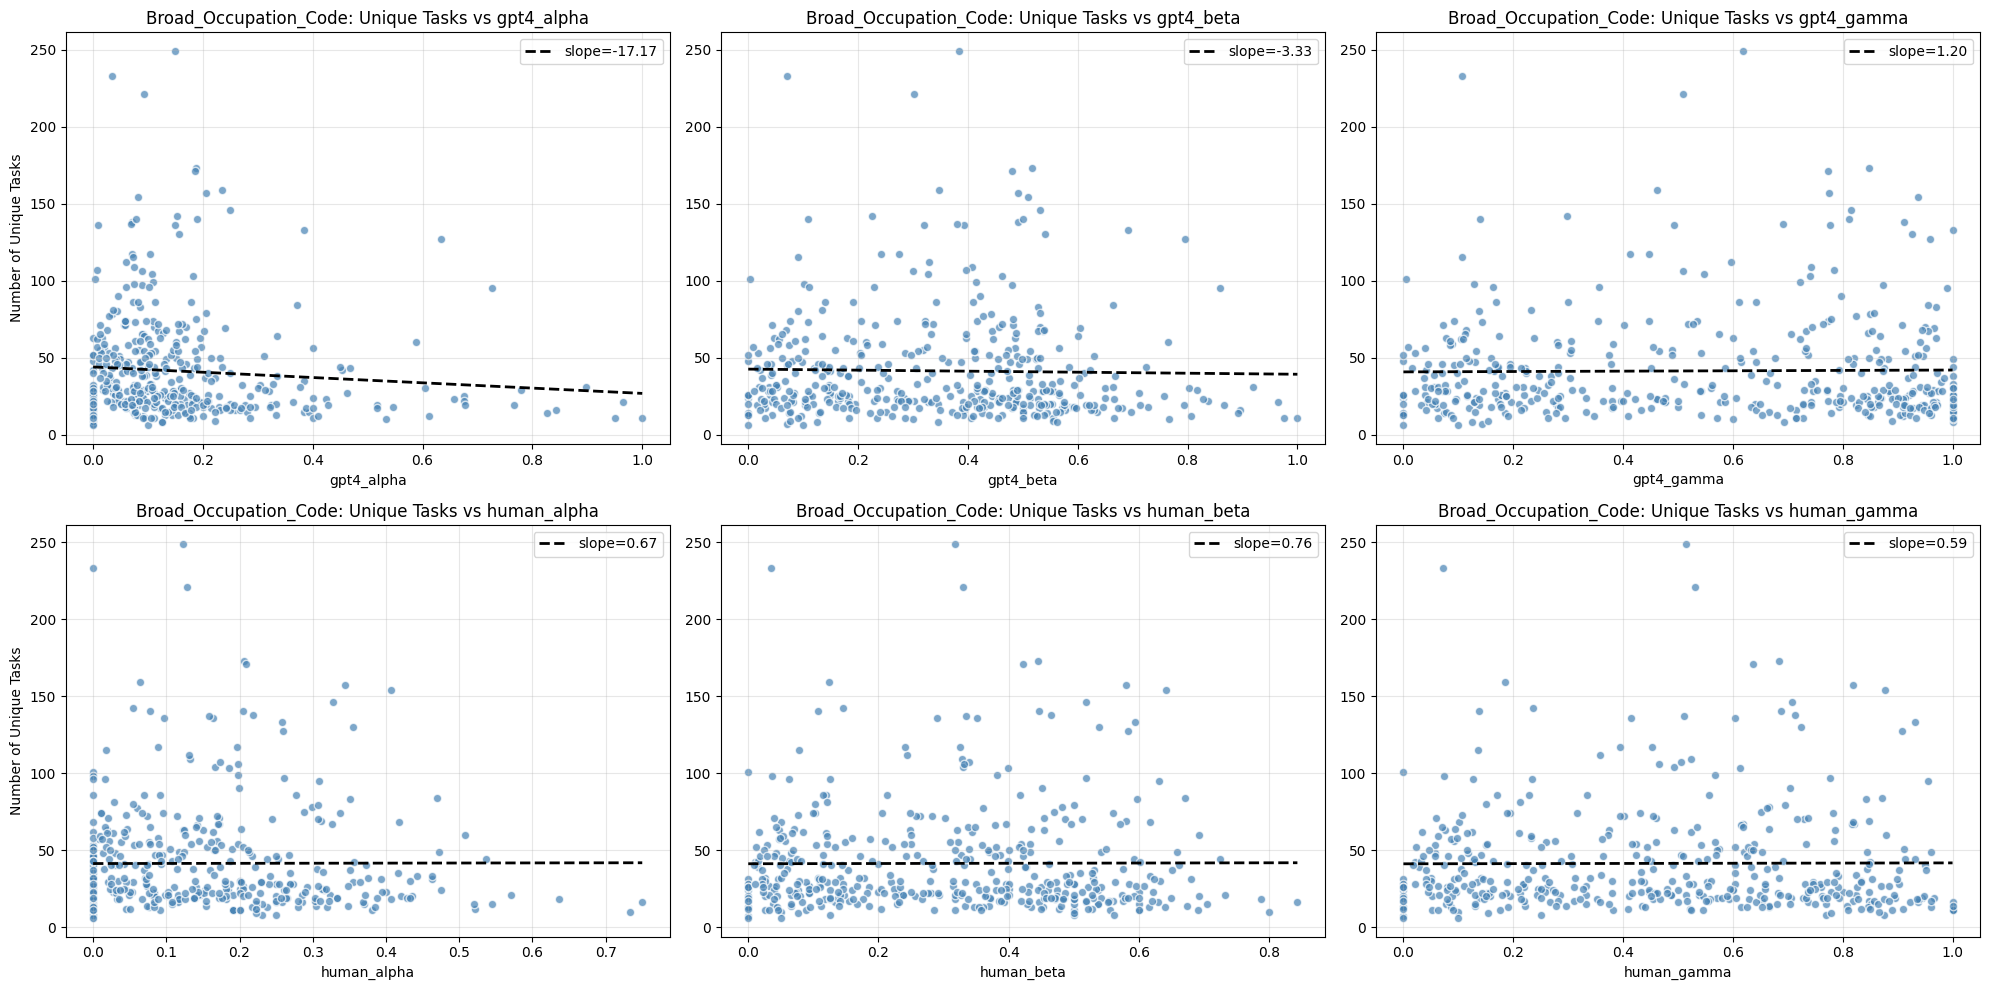

✓ Saved Broad_Occupation_Code tasks vs exposure plot to: ../writeup/plots/industryGroup_exposure/Broad_Occupation_Code_tasks_vs_exposure.png


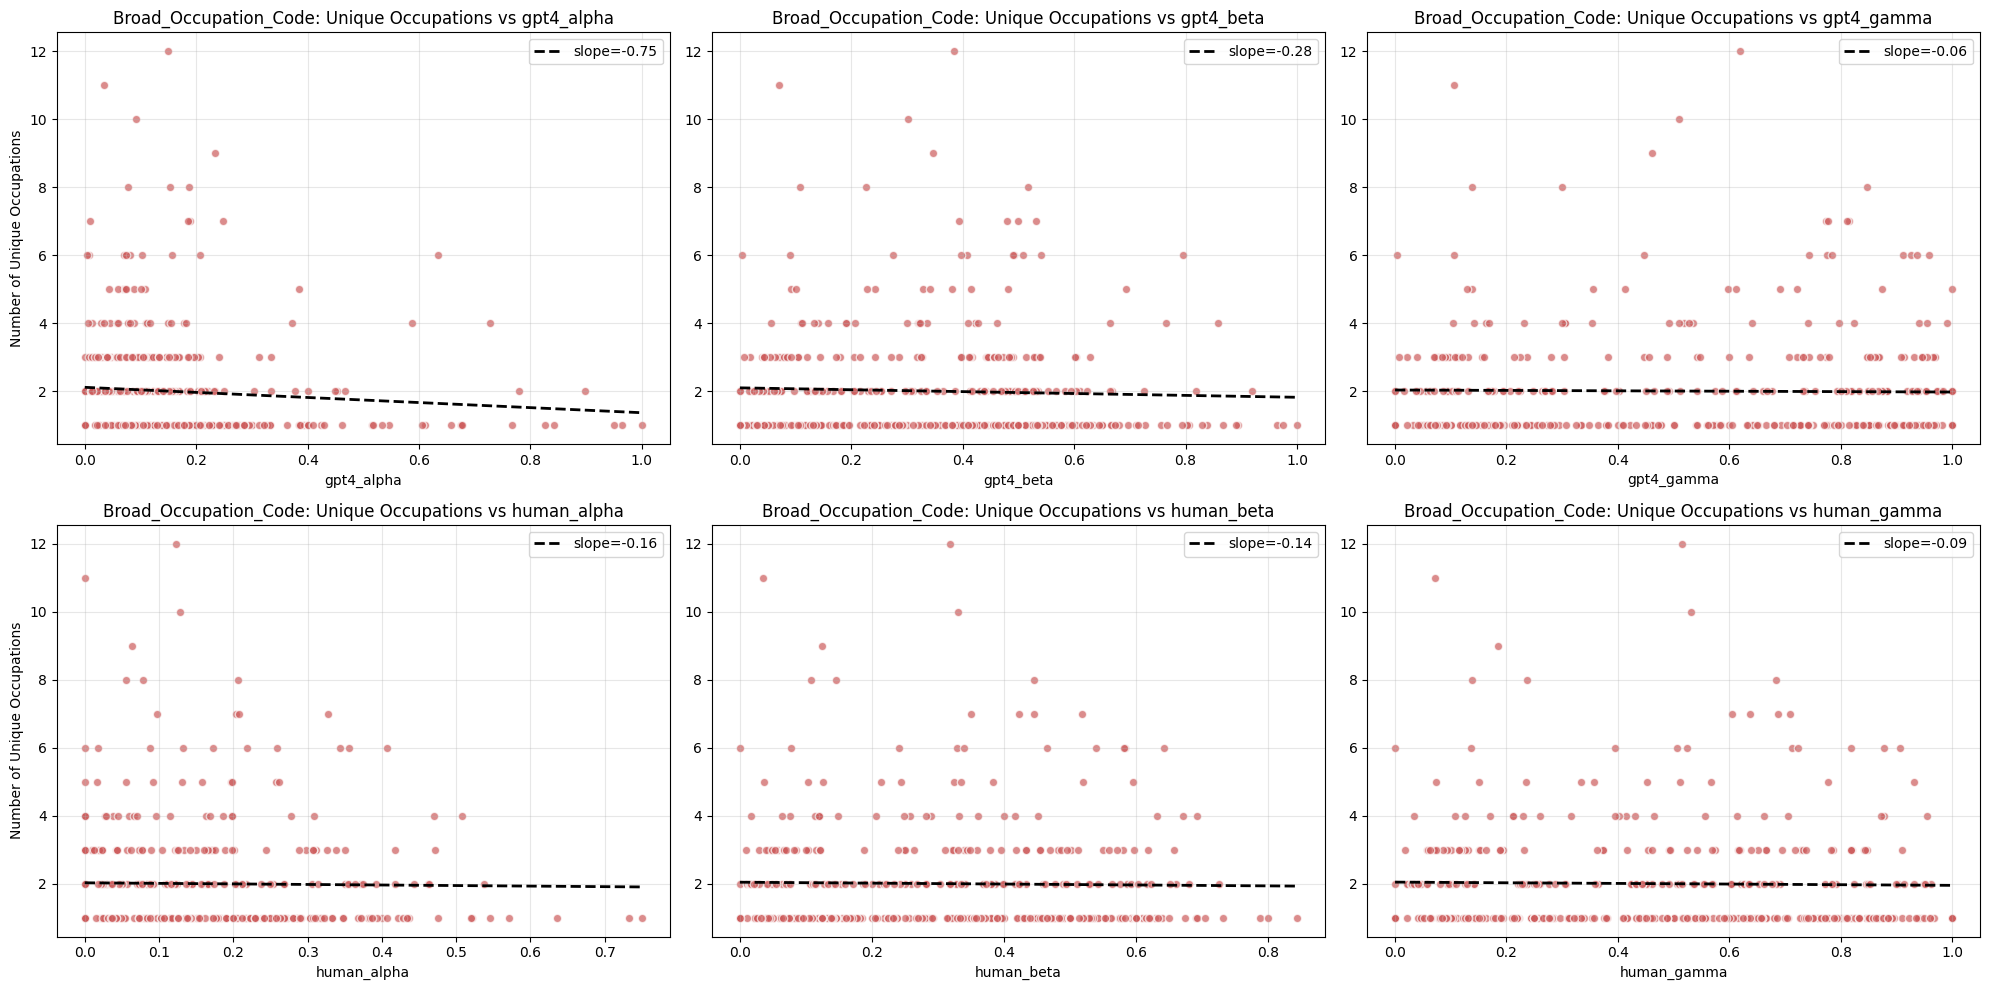

✓ Saved Broad_Occupation_Code occupations vs exposure plot to: ../writeup/plots/industryGroup_exposure/Broad_Occupation_Code_occupations_vs_exposure.png


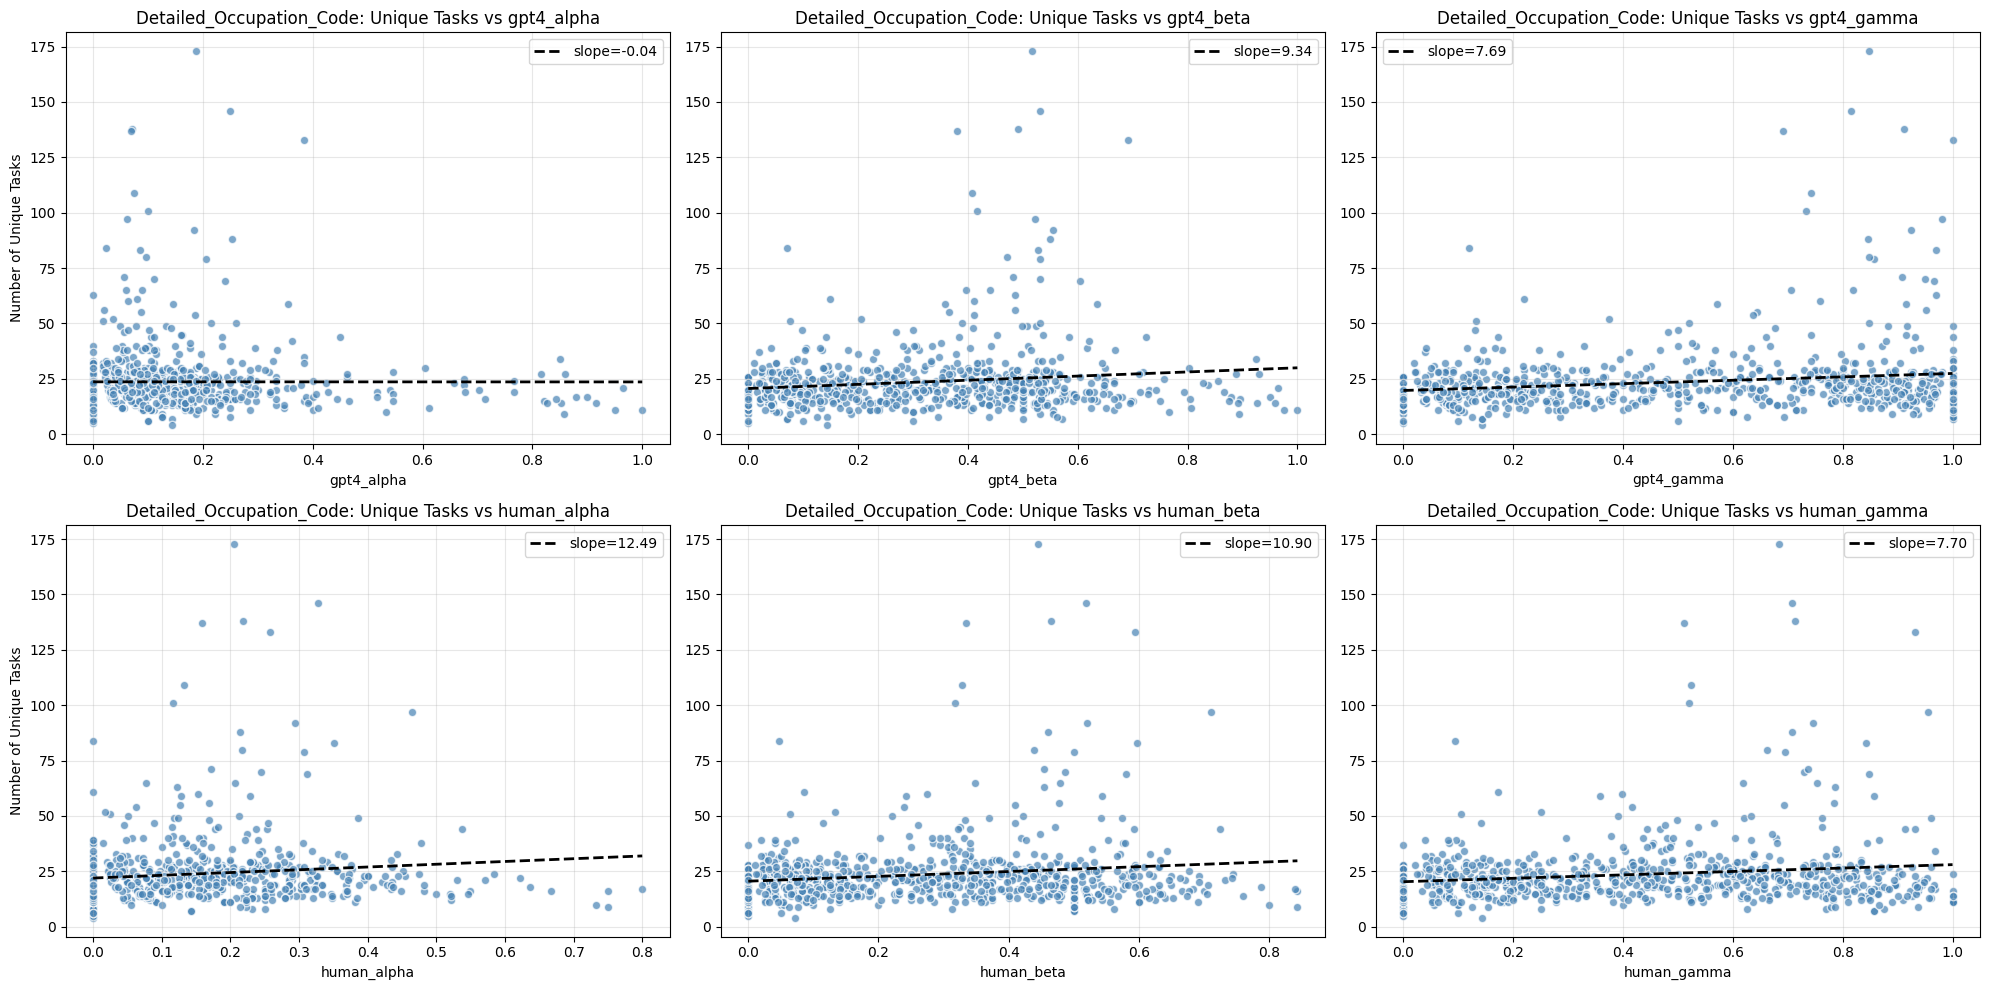

✓ Saved Detailed_Occupation_Code tasks vs exposure plot to: ../writeup/plots/industryGroup_exposure/Detailed_Occupation_Code_tasks_vs_exposure.png


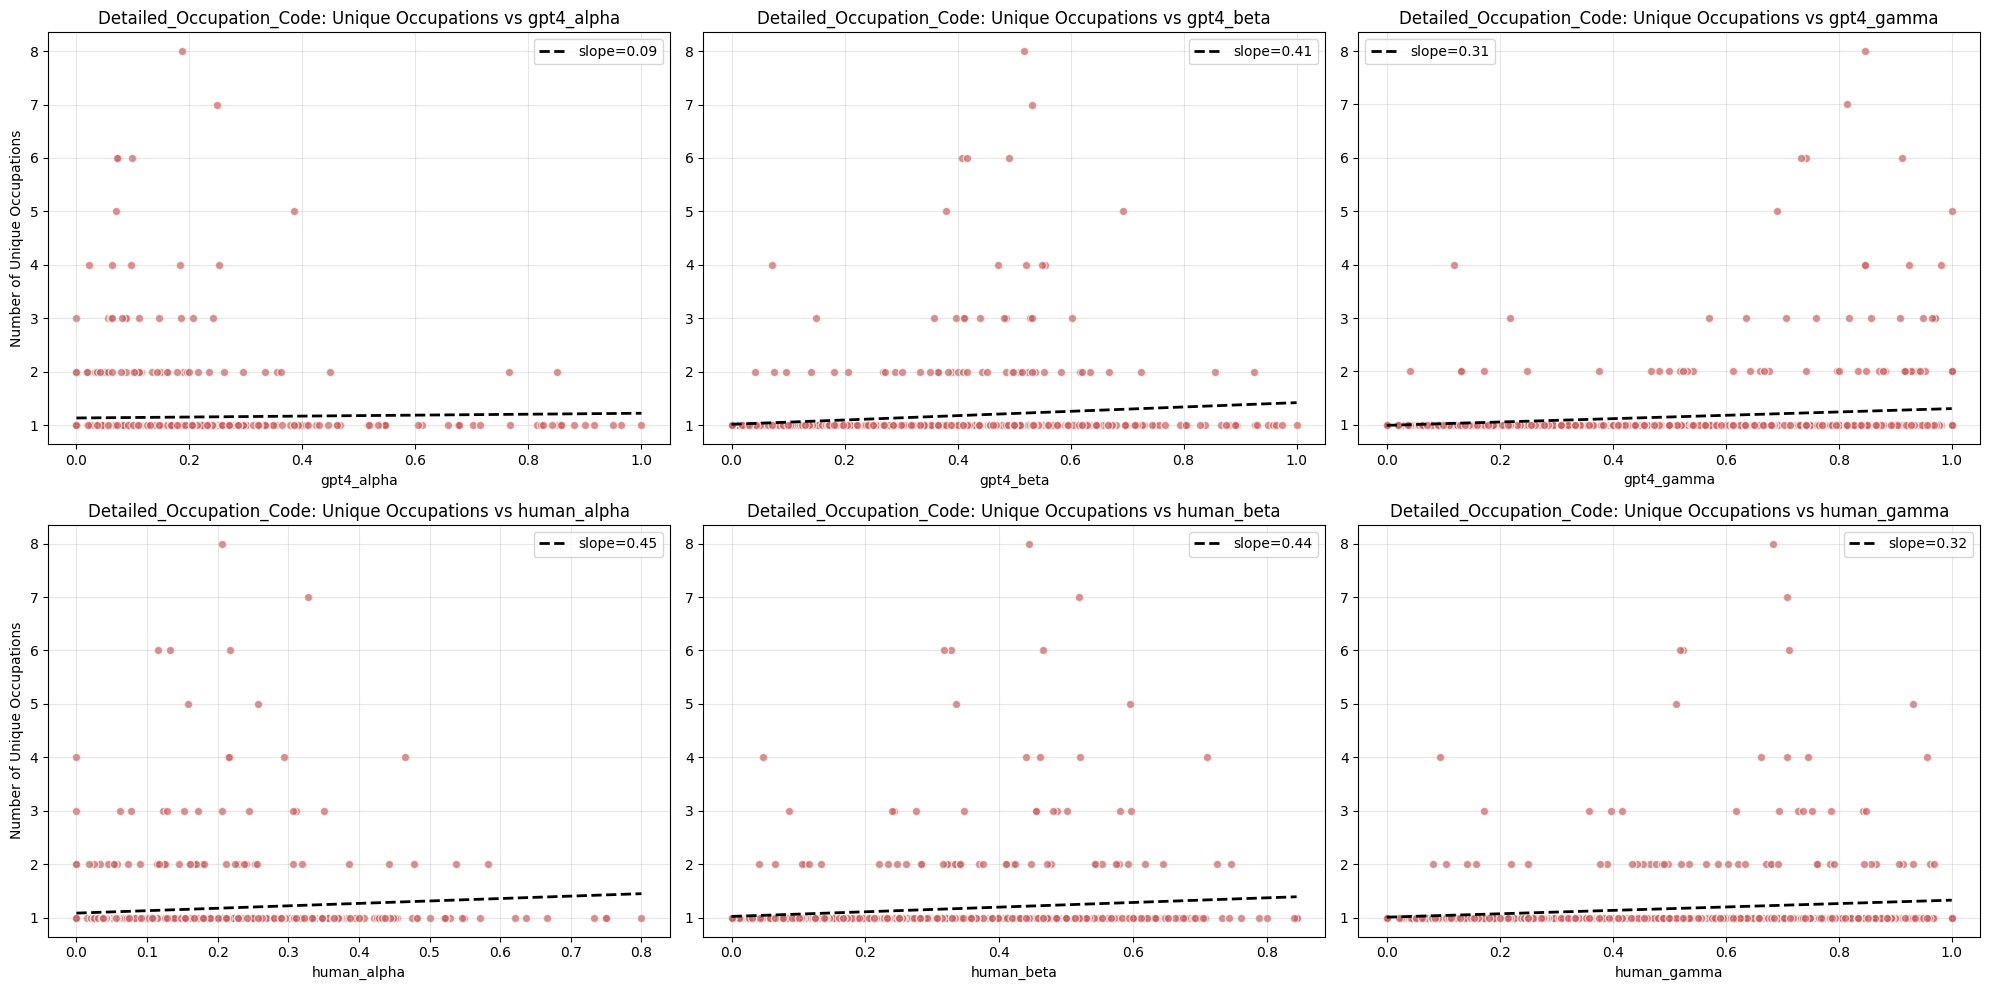

✓ Saved Detailed_Occupation_Code occupations vs exposure plot to: ../writeup/plots/industryGroup_exposure/Detailed_Occupation_Code_occupations_vs_exposure.png


In [112]:
# Plot 2x3 figures for each industry group: unique tasks vs exposure, and unique occupations vs exposure
import matplotlib.pyplot as plt
import numpy as np
group_levels = [
    ('Major_Group_Code', 'Major_Group_Title'),
    ('Minor_Group_Code', 'Minor_Group_Title'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title')
]
exposure_cols = [
    'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
    'human_alpha', 'human_beta', 'human_gamma'
]
input_dir = f'{output_data_path}/industryGroup_exposure'
output_dir = f'{output_plot_path}/industryGroup_exposure'
os.makedirs(output_dir, exist_ok=True)
for code_col, title_col in group_levels:
    df = pd.read_csv(f'{input_dir}/{code_col}_exposure.csv')
    # 2x3: num_unique_tasks vs exposure measures
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
    for i, col in enumerate(exposure_cols):
        ax = axes[i//3, i%3]
        x = df[col].astype(float)
        y = df['num_unique_tasks'].astype(float)
        ax.scatter(x, y, alpha=0.7, color='steelblue', edgecolors='white')
        valid_mask = (~np.isnan(x)) & (~np.isnan(y))
        if valid_mask.sum() > 1:
            coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
            x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
            y_fit = coeffs[0] * x_fit + coeffs[1]
            ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
            ax.legend()
        ax.set_xlabel(f'{col}')
        if i % 3 == 0:
            ax.set_ylabel('Number of Unique Tasks')
        ax.set_title(f'{code_col}: Unique Tasks vs {col}')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plot_file = f'{output_dir}/{code_col}_tasks_vs_exposure.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'✓ Saved {code_col} tasks vs exposure plot to: {plot_file}')
    # 2x3: num_unique_occupations vs exposure measures
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
    for i, col in enumerate(exposure_cols):
        ax = axes[i//3, i%3]
        x = df[col].astype(float)
        y = df['num_unique_occupations'].astype(float)
        ax.scatter(x, y, alpha=0.7, color='indianred', edgecolors='white')
        valid_mask = (~np.isnan(x)) & (~np.isnan(y))
        if valid_mask.sum() > 1:
            coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
            x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
            y_fit = coeffs[0] * x_fit + coeffs[1]
            ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
            ax.legend()
        ax.set_xlabel(f'{col}')
        if i % 3 == 0:
            ax.set_ylabel('Number of Unique Occupations')
        ax.set_title(f'{code_col}: Unique Occupations vs {col}')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plot_file = f'{output_dir}/{code_col}_occupations_vs_exposure.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'✓ Saved {code_col} occupations vs exposure plot to: {plot_file}')